In [44]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

## Publication data

In [2]:
# authorPublicationData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')
authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [3]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [4]:
author_year_numPub.head(10)

author                 year
'maseka lesaoana       2001    1
                       2015    1
(max) zong-ming cheng  2009    1
                       2011    1
(zhou) bryan bai       2011    1
                       2012    1
a aart blokhuis        1992    1
                       2005    1
a ahrabian             2017    1
a el sharkawi          2002    1
Name: pub_id, dtype: int64

In [5]:
author_year_publications = authorPublicationData.groupby(['author', 'year'])['pub_id'].apply(list)

In [6]:
author_year_publications.head()

author                 year
'maseka lesaoana       2001    [4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa]
                       2015    [2a10f544-51ac-4261-8a26-cf61c1abdc03]
(max) zong-ming cheng  2009    [fe824193-57a4-48ed-a1d3-5eeb67929ae4]
                       2011    [fd54f6e8-4b10-471b-a1d0-3c784688a2a7]
(zhou) bryan bai       2011    [53d10a61-f01d-464e-b5e9-8242ed3b9e00]
Name: pub_id, dtype: object

## Author citation data (ids)

In [7]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone.txt')

In [8]:
authorCitationsData.head()
print(authorCitationsData.shape)

(25161834, 3)


In [9]:
paper_citation_count = authorCitationsData.groupby('id2')['id1'].count()

### Generate the new author->author citation network

In [10]:
# final_citation_count_from_ids = authorPublicationData.merge(authorCitationsData, left_on='pub_id', 
#                                                             right_on='id2', how='left', suffixes=('_pub', '_cit'))

# final_citation_count_from_ids = final_citation_count_from_ids.merge(authorPublicationData, left_on='id1', 
#                                                                     right_on='pub_id', how='left', suffixes=('_cited', '_citing'))

In [11]:
# final_citation_count_from_ids.head()

,author_cited,year_pub,pub_id_cited,id1,id2,year_cit,author_citing,year,pub_id_citing
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015.0,roberto scopigno,2015.0,16870052-7e2e-4bbc-beeb-21e493bea221
1,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015.0,matteo dellepiane,2015.0,16870052-7e2e-4bbc-beeb-21e493bea221
2,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015.0,eliana siotto,2015.0,16870052-7e2e-4bbc-beeb-21e493bea221
3,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015.0,marco callieri,2015.0,16870052-7e2e-4bbc-beeb-21e493bea221
4,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015.0,roberto scopigno,2015.0,16870052-7e2e-4bbc-beeb-21e493bea221


In [12]:
# print(final_citation_count_from_ids.shape)
# final_citation_count_from_ids.drop_duplicates(subset=['author_cited', 'pub_id_cited', 'pub_id_citing', 'author_citing'],
#                                               inplace=True)
# print(final_citation_count_from_ids.shape)

(263535955, 9)
(263409178, 9)


In [13]:
# final_citation_count_from_ids.to_csv('./data/authors_cite_2017_asiansAsNone_by_daniel.txt',
#                                      columns=['author_cited', 'author_citing', 'year_cit'], index=False)

In [15]:
# authorCitationsData_only_names = final_citation_count_from_ids[['author_cited', 'author_citing', 'year_cit']]

### Errors in citation data (IDs)

In [ ]:
final_citation_count_from_ids[final_citation_count_from_ids.year_pub <= final_citation_count_from_ids.year_cit].shape

In [ ]:
final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].shape

In [ ]:
final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].head()

## Author citation data (names)

In [16]:
authorCitationsData_only_names = pd.read_csv('./data/authors_cite_2017_asiansAsNone_by_daniel.txt')
# authorCitationsData_only_names = pd.read_csv('./data/authors_cite_2017_asiansAsNone.txt')

In [17]:
authorCitationsData_only_names.rename(columns={'author_cited':'id2', 'author_citing':'id1', 'year_cit':'year'}, inplace=True)

/home/danielkostic/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [20]:
print(authorCitationsData_only_names.shape)
authorCitationsData_only_names.head()

(263409178, 3)


,id2,id1,year
0,graeme earl,roberto scopigno,2015.0
1,graeme earl,matteo dellepiane,2015.0
2,graeme earl,eliana siotto,2015.0
3,graeme earl,marco callieri,2015.0
4,gareth beale,roberto scopigno,2015.0


In [21]:
final_citation_count = authorCitationsData_only_names.groupby('id2')['id1'].count()

## Author career information

In [23]:
credible_authors = pd.read_csv('data/authors-scientific-atleast-15-year.csv')

In [24]:
credible_authors.set_index('author', inplace=True, )

In [25]:
credible_authors.head(10)

,start_year,end_year,total_num_pub,career_length
author,,,,
a min tjoa,1979,2017,191,38
a-xing zhu,1998,2017,22,19
a. a. (louis) beex,1980,2016,31,36
a. a. abouelsoud,1996,2016,10,20
a. a. ball,1988,2006,5,18
a. a. elsadany,2002,2017,7,15
a. a. goldstein,1977,1993,2,16
a. a. khan,1994,2016,9,22
a. a. naik,1992,2014,2,22


## Early career analysis

In [26]:
# This part adds data to credible_authors file. This can be stored for later use. 
# At the moment, only career quality is done correct.
# TODO fix final citation and career prod., and save all to new file

In [27]:
EARLY_CAREER_LEN = 3

In [28]:
def get_early_career_prod(row, num_years):
    early_prod = 0
    author = row.name
    start_year = row['start_year']
    year_num_pub = author_year_numPub[author]
    for year in range(num_years):
        if start_year + year in year_num_pub:
            early_prod += year_num_pub[start_year + year]
    return early_prod

In [29]:
credible_authors['early_career_prod'] = credible_authors.apply(lambda x: get_early_career_prod(x, EARLY_CAREER_LEN), axis=1)

In [30]:
def get_early_career_quality(row, num_years):
    early_pubs = []
    author = row.name
    start_year = row['start_year']
    year_pubs = author_year_publications[author]
    for year in range(num_years):
        if start_year + year in year_pubs:
            early_pubs.extend(year_pubs[start_year + year])
#     print(early_pubs)
    return sum([paper_citation_count[paper] for paper in early_pubs if paper in paper_citation_count])
    # TODO finish this with citation data

In [31]:
credible_authors['early_career_qual'] = credible_authors.apply(lambda x: get_early_career_quality(x, EARLY_CAREER_LEN), axis=1)

In [32]:
credible_authors['final_citation_count'] = final_citation_count
credible_authors['final_citation_count'] = credible_authors['final_citation_count'].fillna(0)

## Test for errors in files

In [ ]:
year_pubs = author_year_publications['manfeng hu']

In [ ]:
year_pubs

In [ ]:
get_early_career_quality(credible_authors.loc['manfeng hu'], 3)

In [ ]:
print(authorPublicationData[authorPublicationData.author == 'martin raußen'].merge(paper_citation_count.to_frame(), left_on='pub_id', right_index=True))

In [59]:
authorCitationsData_only_names[authorCitationsData_only_names.id2 == 'martin raußen']

,id2,id1,year
93899524,martin raußen,peter mcburney,2002.0
93899525,martin raußen,simon parsons,2002.0
93899526,martin raußen,samuel mimram,2012.0
93899527,martin raußen,eric goubault,2012.0
93899528,martin raußen,emmanuel haucourt,2006.0
93899529,martin raußen,emmanuel haucourt,2004.0
93899530,martin raußen,eric goubault,2004.0
93899531,martin raußen,martin raussen,2012.0
93899532,martin raußen,rob j. van glabbeek,2005.0
93899533,martin raußen,dominic verity,2002.0


In [58]:
final_citation_count['martin raußen']

126

In [ ]:
paper_citation_count['d2d9c3dc-852f-41f5-badb-b6113810edac']

In [57]:
credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual].shape

(0, 7)

In [55]:
authors_50k = credible_authors[credible_authors['final_citation_count'] > 49000].index

In [56]:
authors_50k

Index(['robert tappan morris', 'h. vincent poor', 'michael i. jordan',
       'hector garcia-molina', 'jitendra malik', 'thomas wiegand',
       'david g. lowe', 'takeo kanade', 'alan c. bovik', 'andrew mccallum',
       'andrew y. ng', 'philip s. yu', 'wolfram burgard', 'matti pietikäinen',
       'ian f. akyildiz', 'hans-peter kriegel', 'luc j. van gool',
       'georgios b. giannakis', 'cordelia schmid', 'donald f. towsley',
       'anil k. jain 1', 'geoffrey e. hinton', 'robert e. schapire',
       'sebastian thrun', 'ian t. foster', 'hari balakrishnan',
       'andrew zisserman', 'chih-jen lin', 'pietro perona', 'trevor darrell',
       'david e. culler', 'scott shenker', 'bill triggs', 'christos faloutsos',
       'rakesh agrawal', 'emmanuel j. candès', 'rajkumar buyya',
       'jeffrey g. andrews', 'yoshua bengio', 'david r. karger',
       'jiawei han 1', 'deborah estrin', 'francisco herrera',
       'richard szeliski', 'samuel madden', 'michael j. franklin',
       'bernhard s

In [ ]:
#credible_authors.drop(authors_50k, inplace=True)

## Citations distribution (based on names file)

In [33]:
citation_distribution = credible_authors['final_citation_count'].value_counts().sort_index()

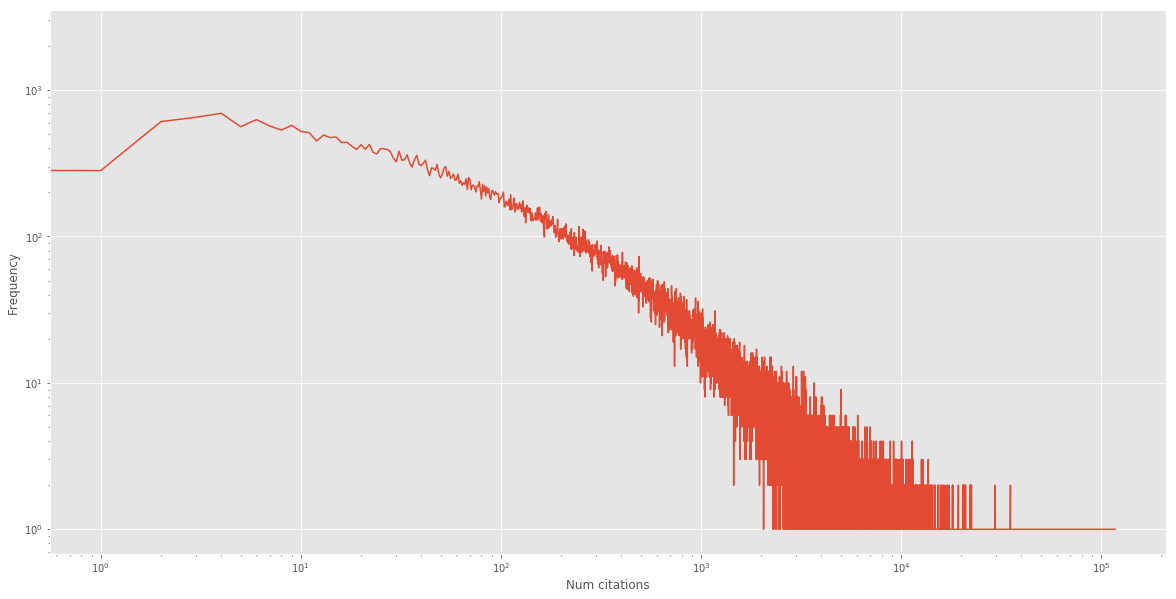

In [45]:
plt.loglog(citation_distribution.index, citation_distribution.values)
plt.xlabel('Num citations')
plt.ylabel('Frequency')
plt.show()

## Early Career Prod. vs Final Success (names file)

In [46]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

In [47]:
x = credible_authors['early_career_prod']
y = credible_authors['final_citation_count']

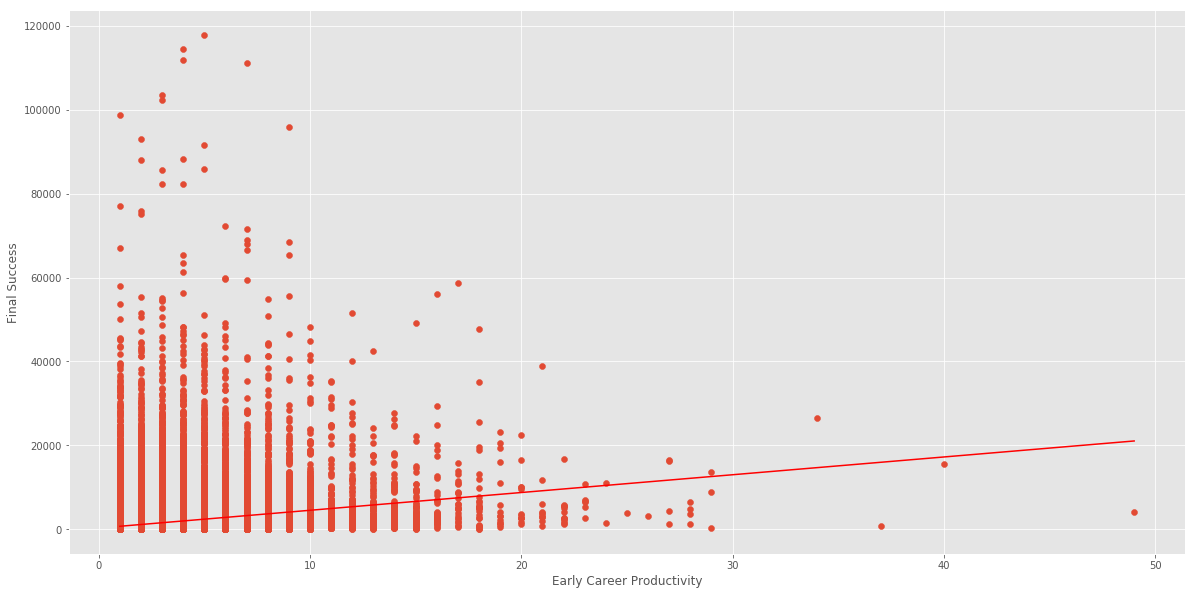

In [48]:
fig, ax = plt.subplots()
plt.scatter(x, y)
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Early Career Productivity')
plt.ylabel('Final Success')
# plt.xlim(0, 50)
# plt.ylim(0,200)
plt.show()

In [49]:
credible_authors_no_uncited = credible_authors.dropna()

In [50]:
x = credible_authors_no_uncited['early_career_prod']
y = credible_authors_no_uncited['final_citation_count']

In [51]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value)
print(slope, intercept)

0.25646353991349796
423.91522495074787 245.0100726810207


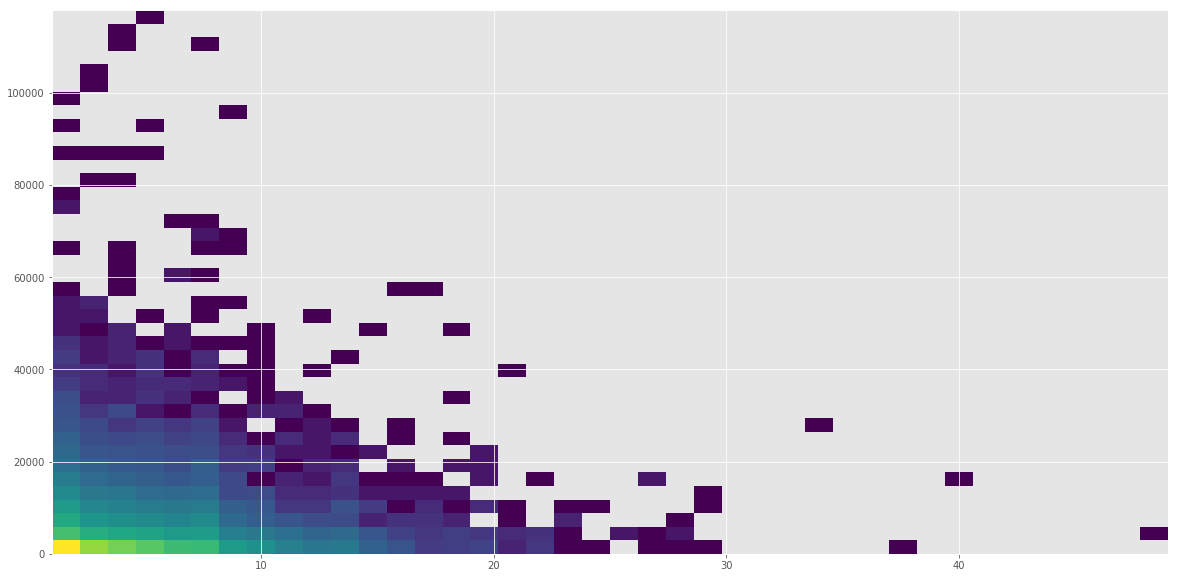

In [52]:
fig, axs = plt.subplots()
axs.hist2d(x, y, bins=40, norm=colors.LogNorm())
plt.show()

## Early Career Prod. vs Early Career Qual. (IDs file)

In [53]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

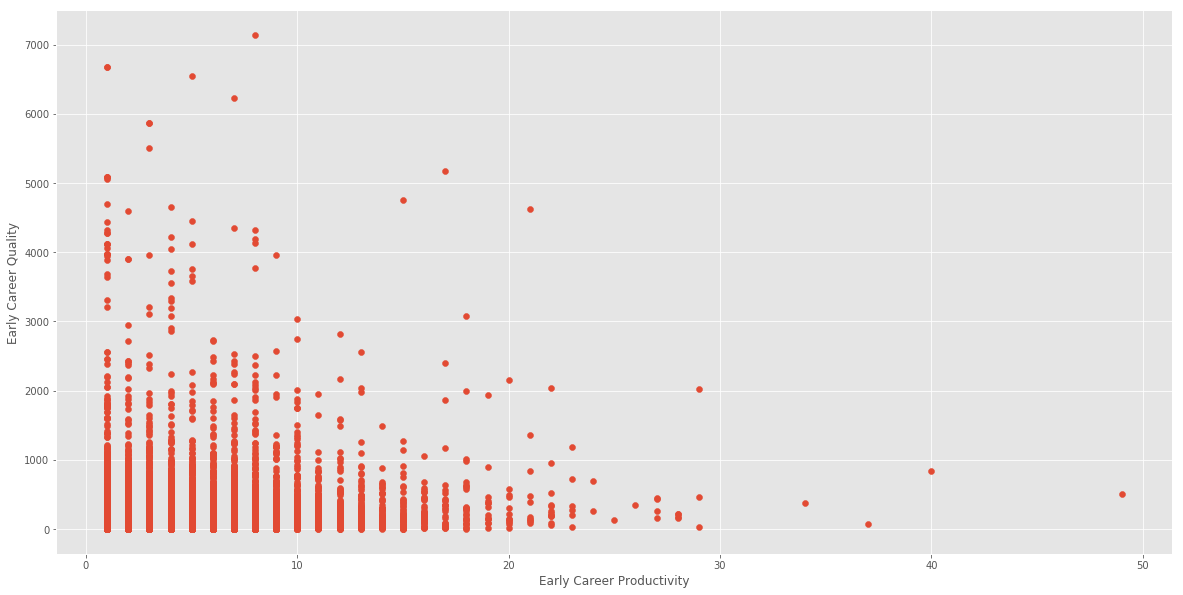

In [54]:
plt.scatter(credible_authors['early_career_prod'], credible_authors['early_career_qual'])
plt.xlabel('Early Career Productivity')
plt.ylabel('Early Career Quality')
plt.show()